In [15]:
from petitRADTRANS import Radtrans
import petitRADTRANS.retrieval_examples.emission.master_retrieval_model as rm
from petitRADTRANS import nat_cst as nc
import petitRADTRANS.rebin_give_width as rgw
from scipy.interpolate import interp1d
import sklearn

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import sys
np.set_printoptions(threshold=sys.maxsize)


from torch.distributions import Independent, Distribution
sys.path.insert(1, '/home/mvasist/scripts/')
from fab_priors import BoxUniform_New

import torch
from sbi.inference import SNRE_A, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi.types import Array, OneOrMore, ScalarFloat


retrieval_name = 'JWST_emission_petitRADTRANSpaper'
absolute_path = 'output/'# end with forward slash!
op= '/home/mvasist/petitRADTRANS/petitRADTRANS/retrieval_examples/emission/'
observation_files = {}
# observation_files['NIRISS SOSS'] = op +'NIRISS_SOSS_flux.dat'
# observation_files['NIRSpec G395M'] = op +'NIRSpec_G395M_flux.dat'
observation_files['MIRI LRS'] = op +'MIRI_LRS_flux.dat'

# Wavelength range of observations, fixed parameters that will not be retrieved
WLENGTH = [0.3, 15.0]
# LOG_G =  2.58
R_pl =   1.84*nc.r_jup_mean
R_star = 1.81*nc.r_sun
# Get host star spectrum to calculate F_pl / F_star later.
T_star = 6295.
x = nc.get_PHOENIX_spec(T_star)
fstar = interp1d(x[:,0], x[:,1])
   
####################################################################################
####################################################################################
### READ IN OBSERVATION
####################################################################################
####################################################################################

# Read in data, convert all to cgs!

data_wlen = {}
data_flux_nu = {}
data_flux_nu_error = {}
data_wlen_bins = {}

for name in observation_files.keys():
    print(name)
    dat_obs = np.genfromtxt(observation_files[name])
    data_wlen[name] = dat_obs[:,0]*1e-4
    data_flux_nu[name] = dat_obs[:,1]
    data_flux_nu_error[name] = dat_obs[:,2]

    data_wlen_bins[name] = np.zeros_like(data_wlen[name])
    data_wlen_bins[name][:-1] = np.diff(data_wlen[name])
    data_wlen_bins[name][-1] = data_wlen_bins[name][-2]
    
    
def Simulator(params): 

    NaN_spectra = 0

    atmosphere = Radtrans(line_species = ['H2O', 'CO_all_iso', \
                                         'CO2', 'CH4', \
                                          'Na', 'K'], \
          rayleigh_species = ['H2', 'He'], \
          continuum_opacities = ['H2-H2', 'H2-He'], \
          wlen_bords_micron = [0.3, 15])#, mode='c-k')


    pressures = np.logspace(-6, 2, 100)
    atmosphere.setup_opa_structure(pressures)
    temperature = 1200. * np.ones_like(pressures)

    R_pl = 1.838*nc.r_jup_mean
    log_gravity = params[2].numpy()                           #params[5].numpy() 1e1**2.45 
    P0 = 0.01                                             #params[6].numpy()

    kappa_IR = 0.01
    log_gamma = params[0].numpy()                         #0.4
    t_int = params[3].numpy()                             #200. params[1].numpy()
    t_equ = params[1].numpy()                             #1500.

    gamma = np.exp(log_gamma)
    gravity = np.exp(log_gravity)
    temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, t_int, t_equ)
    
    abundances = {}
    abundances['H2'] = 0.75 * np.ones_like(temperature) #0.74 * np.ones_like(temperature) (params[3].numpy())
    abundances['He'] = 0.25 * np.ones_like(temperature)  #0.24 * np.ones_like(temperature) (params[4].numpy())
    abundances['H2O'] = 0.001 * np.ones_like(temperature)
    abundances['CO_all_iso'] = 0.01 * np.ones_like(temperature)
    abundances['CO2'] = 0.00001 * np.ones_like(temperature)
    abundances['CH4'] = 0.000001 * np.ones_like(temperature)
    abundances['Na'] = 0.00001 * np.ones_like(temperature)
    abundances['K'] = 0.000001 * np.ones_like(temperature)

    MMW = rm.calc_MMW(abundances) * np.ones_like(temperature)
    #print(MMW, abundances)
    
    atmosphere.calc_flux(temperature, abundances, gravity, MMW)

    wlen, flux_nu = nc.c/atmosphere.freq, atmosphere.flux/1e-6


    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(flux_nu)) > 0:
        print("NaN spectrum encountered")
        NaN_spectra += 1
        return torch.ones([1,371])* -np.inf

    # Convert to observation for emission case
    flux_star = fstar(wlen)
    flux_sq   = flux_nu/flux_star*(R_pl/R_star)**2 

    flux_rebinned = rgw.rebin_give_width(wlen, flux_sq, \
                data_wlen['MIRI LRS'], data_wlen_bins['MIRI LRS'])

    #flux_rebinned = np.reshape(flux_rebinned, (371,1))    

    FR= torch.Tensor(flux_rebinned)
    
    p1, t1 = pressures, temperature

    return FR,  wlen, flux_nu, p1, t1

    
################################################################################################################
    
temp_params = {}
temp_params['log_delta'] = -5.5
temp_params['log_gamma'] = np.log10(0.4)
temp_params['t_int'] = 750.
temp_params['t_equ'] = 0.
temp_params['log_p_trans'] = -3.
temp_params['alpha'] = -0.25
pressures, temperature = nc.make_press_temp(temp_params)

# Create the Ratrans object here
rt_object = Radtrans(line_species=['H2O', 'CO_all_iso', \
                                         'CO2', 'CH4', \
                                          'Na', 'K'], \
                    rayleigh_species=['H2','He'], \
                    continuum_opacities = ['H2-H2','H2-He'], \
                    mode='c-k', \
                    wlen_bords_micron=WLENGTH)

# Create the RT arrays of appropriate lengths
rt_object.setup_opa_structure(pressures)

def Simulator_paul(params): 
    ##################

    NaN_spectra = 0
    
    log_gamma = params[0].numpy()[0]                            #log(0.4)
    t_equ = params[1].numpy()[0]                                #1500.
    log_gravity = params[2].numpy()[0]                                #params[5] 2.45 
    
    # Make dictionary for modified Guillot parameters
    temp_params['log_gamma'] = log_gamma
    temp_params['t_equ'] = t_equ
    
    log_P0 = -2.                                      #params[6] 
  
    gravity = np.exp(log_gravity)
    P0 = np.exp(log_P0)
    gamma = np.exp(log_gamma)

    
    # Make dictionary for log 'metal' abundances    
    abundances_metals = {}
        
    abundances_metals['H2O'] = -3              #np.exp(params[7]) * np.ones_like(temperature)
    abundances_metals['CO_all_iso'] = -2       #np.exp(params[8]) * np.ones_like(temperature)
    abundances_metals['CO2'] = -5              #np.exp(params[9]) * np.ones_like(temperature)
    abundances_metals['CH4'] = -6              #np.exp(params[10]) * np.ones_like(temperature)
    abundances_metals['Na'] = -5               #np.exp(params[11]) * np.ones_like(temperature)
    abundances_metals['K'] = -6                #np.exp(params[12]) * np.ones_like(temperature)
    
    ####################################################################
    ####################################################################

    
    wlen, flux_nu = \
            rm.retrieval_model_plain(rt_object, temp_params, log_gravity, \
                                         log_P0, R_pl, abundances_metals)
    flux_nu = flux_nu/1e-6
    
    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(flux_nu)) > 0:
        print("NaN spectrum encountered")
        NaN_spectra += 1
        return -np.inf    

    # Convert to observation for emission case
    flux_star = fstar(wlen)
    flux_sq   = flux_nu/flux_star*(R_pl/R_star)**2 
    
    # Rebin model to observation
    flux_rebinned = rgw.rebin_give_width(wlen, flux_sq, \
                    data_wlen['MIRI LRS'], data_wlen_bins['MIRI LRS'])
    
    FR= torch.Tensor(flux_rebinned)
    
    p2, t2 = nc.make_press_temp(temp_params)
    
    return FR, wlen, flux_nu, p2, t2



MIRI LRS

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



In [16]:
# observation = Simulator([torch.ones(1)*1.5,torch.ones(1)*750.,torch.ones(1)*2000., torch.ones(1)*0.74, \
#                          torch.ones(1)*0.24, torch.ones(1)*np.exp(2.45), torch.ones(1)*0.01])
#observation, wlmo, modiff, p2, t2 = Simulator_paul([torch.ones(1)*1.5,torch.ones(1)*2000.,torch.ones(1)*2.58])
# observation1, wldi, direct, p1, t1 = Simulator([torch.ones(1)*1.5,torch.ones(1)*2000.,torch.ones(1)*2.58])

In [17]:
# t_int


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



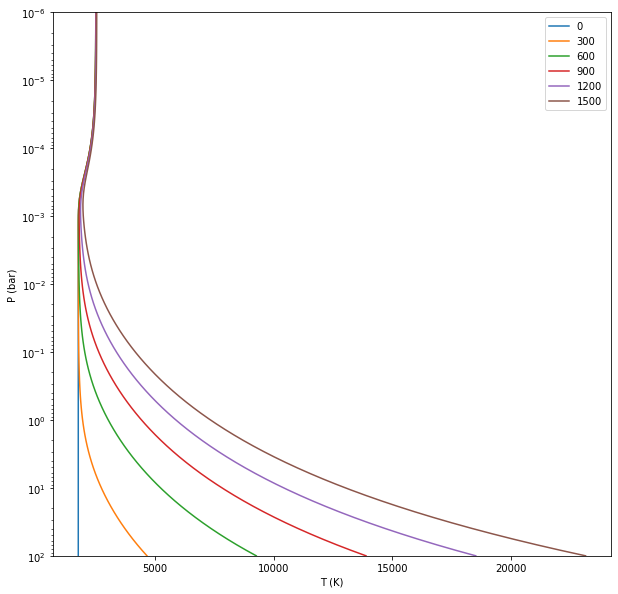

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(10,10))
for tint in np.arange(0,1800,300):
    observation1, wldi, direct, p1, t1 = Simulator([torch.ones(1)*1.5,torch.ones(1)*2000.,torch.ones(1)*2.58, torch.ones(1)* tint])
    plt.plot(t1, p1, label= str(np.round(tint, 1)))
    plt.yscale('log')
    plt.ylim([1e2, 1e-6])
    plt.xlabel('T (K)')
    plt.ylabel('P (bar)')
    
plt.legend()
plt.show()
plt.clf()

In [ ]:
# log gravity


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



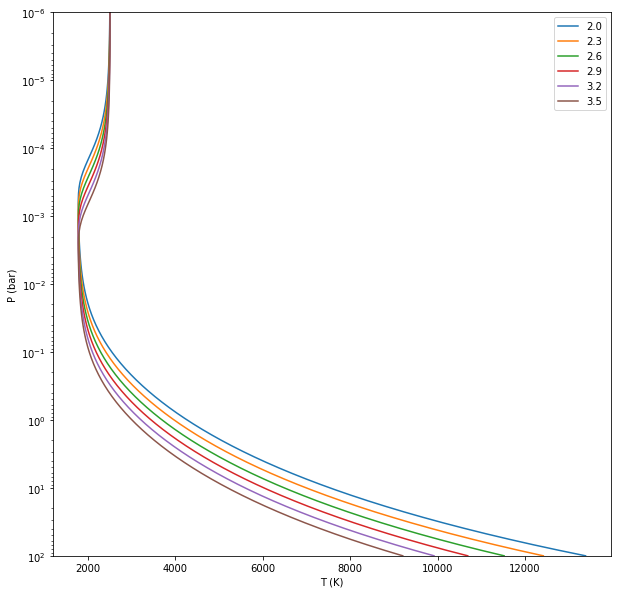

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(10,10))
for lg in np.arange(2.0,3.8,0.3):
    observation1, wldi, direct, p1, t1 = Simulator([torch.ones(1)*1.5,torch.ones(1)*2000.,torch.ones(1)*lg])
    plt.plot(t1, p1, label= str(np.round(lg, 1)))
    plt.yscale('log')
    plt.ylim([1e2, 1e-6])
    plt.xlabel('T (K)')
    plt.ylabel('P (bar)')
    
plt.legend()
plt.show()
plt.clf()

In [ ]:
# log gamma


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



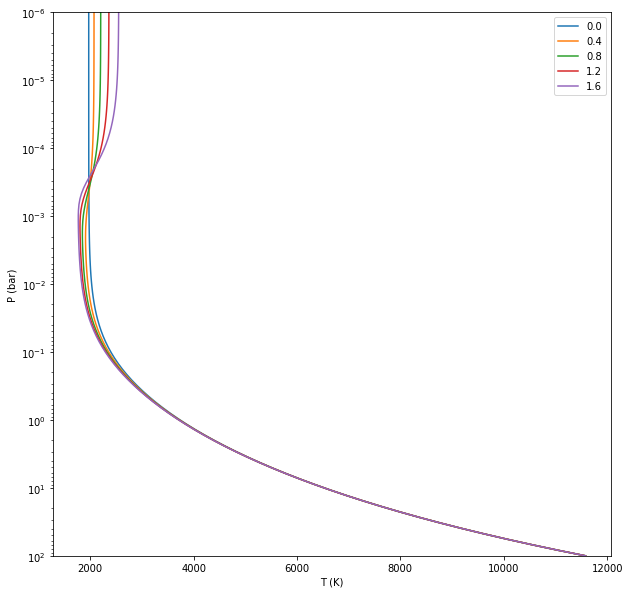

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure(figsize=(10,10))
for lg in np.arange(0.,2.0, 0.4):
    observation1, wldi, direct, p1, t1 = Simulator([torch.ones(1)*lg,torch.ones(1)*2000.,torch.ones(1)*2.58])
    plt.plot(t1, p1, label= str(np.round(lg, 1)))
    plt.yscale('log')
    plt.ylim([1e2, 1e-6])
    plt.xlabel('T (K)')
    plt.ylabel('P (bar)')
    
plt.legend()
plt.show()
plt.clf()

In [ ]:
# Tequ


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



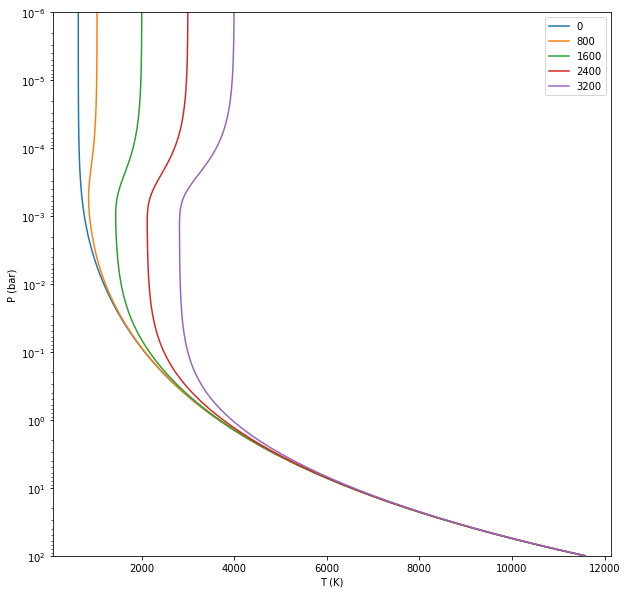

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figsize=(10,10))
for teq in np.arange(0,4000, 800):
    observation1, wldi, direct, p1, t1 = Simulator([torch.ones(1)*1.5,torch.ones(1)*teq,torch.ones(1)*2.58])
    plt.plot(t1, p1, label= str(np.round(teq, 1)))
    plt.yscale('log')
    plt.ylim([1e2, 1e-6])
    plt.xlabel('T (K)')
    plt.ylabel('P (bar)')
    
plt.legend()
plt.show()
plt.clf()

In [ ]:
# plt.plot(t2, p2, label= 'modiff')
# plt.plot(t1, p1, label = 'direct')

# plt.yscale('log')
# plt.ylim([1e2, 1e-6])
# plt.xlabel('T (K)')
# plt.ylabel('P (bar)')
# plt.legend()
# plt.show()
# plt.clf()